ideas: 
* https://ijarsct.co.in/Paper4350.pdf

* https://sahilvaidya99.medium.com/spoiler-detection-in-movie-reviews-51312d6146ef
* https://www.sas.com/content/dam/SAS/support/en/sas-global-forum-proceedings/2020/5012-2020.pdf (86% accuracy)

# Data preparing

In [ ]:
# https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset

import json
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

df_movie_details = pd.read_json('/content/drive/My Drive/CS3244 project/IMDB_movie_details.json', lines = True)
df_reviews = pd.read_json('/content/drive/My Drive/CS3244 project/IMDB_reviews.json', lines = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'pd' is not defined

In [2]:
# If using jupyter notebook
import json
import pandas as pd
import os

print(os.getcwd())

df_movie_details = pd.read_json('../datasets/IMDB_movie_details.json', lines = True)
df_reviews = pd.read_json('../datasets/IMDB_reviews.json', lines = True)

/media/randell-crapy/0E9103460E910346/NUS/CS3244/project


In [ ]:
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [61]:
print('User reviews shape: ', df_reviews.shape)
print(df_reviews.info())
df_reviews.head(10)

User reviews shape:  (573913, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB
None


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
5,12 August 2004,tt0111161,ur1532177,True,In recent years the IMDB top 250 movies has ha...,8,"Good , But It Is Overrated By Some"
6,9 October 2005,tt0111161,ur6574726,True,I have been a fan of this movie for a long tim...,9,This Movie Saved My Life.
7,4 February 2012,tt0111161,ur31182745,True,I made my account on IMDb Just to Rate this mo...,10,Movie you can see 1000 times
8,24 October 2008,tt0111161,ur9871443,True,"A friend of mine listed ""The Shawshank Redempt...",10,The Shawshank Redemption
9,30 July 2011,tt0111161,ur2707735,True,Well I guess I'm a little late to the party as...,10,"""I'm a convicted murderer who provides sound f..."


We have a total of 573,913 user reviews. <br>
Each review comes with a label True or False depending on the spoiler content in the review.

In [6]:
print('Movie details shape: ', df_movie_details.shape)
print(df_movie_details.info())
df_movie_details.head(10)

Movie details shape:  (1572, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB
None


,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...
5,tt0286716,"Bruce Banner, a brilliant scientist with a clo...",2h 18min,"[Action, Sci-Fi]",5.7,2003-06-20,Bruce Banner (Eric Bana) is a research scienti...
6,tt0090605,57 years after Ellen Ripley had a close encoun...,2h 17min,"[Action, Adventure, Sci-Fi]",8.4,1986-07-18,"After the opening credits, we see a spacecraft..."
7,tt0243155,Bridget Jones is an average woman struggling a...,1h 37min,"[Comedy, Drama, Romance]",6.7,2001-04-13,Bridget Jones (adorably played by Renee Zellwe...
8,tt0121765,"Ten years after the invasion of Naboo, the Gal...",2h 22min,"[Action, Adventure, Fantasy]",6.6,2002-05-16,The opening crawl reveals that the Galactic Re...
9,tt0443453,Borat Sagdiyev is a TV reporter of a popular s...,1h 24min,[Comedy],7.3,2006-11-03,Borat Sagdiyev is a TV reporter of a popular s...


We have a total of 1572 movies.

## Datasets merging

In [3]:
# remove '/' in the movie_id 

df_movie_details['movie_id'] = df_movie_details['movie_id'].str.replace('/', '')
df_movie_details['movie_id']

0       tt0105112
1       tt1204975
2       tt0243655
3       tt0040897
4       tt0126886
          ...    
1567    tt0289879
1568    tt1723811
1569    tt5013056
1570    tt0104014
1571    tt0114142
Name: movie_id, Length: 1572, dtype: object

We merge the two datasets.

In [4]:
df = pd.merge(df_reviews, df_movie_details, on = 'movie_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573913 entries, 0 to 573912
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review_date     573913 non-null  object 
 1   movie_id        573913 non-null  object 
 2   user_id         573913 non-null  object 
 3   is_spoiler      573913 non-null  bool   
 4   review_text     573913 non-null  object 
 5   rating_x        573913 non-null  int64  
 6   review_summary  573913 non-null  object 
 7   plot_summary    573913 non-null  object 
 8   duration        573913 non-null  object 
 9   genre           573913 non-null  object 
 10  rating_y        573913 non-null  float64
 11  release_date    573913 non-null  object 
 12  plot_synopsis   573913 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 57.5+ MB


Change the column names. <br>
rating_x -> user_rating <br>
rating_y -> movie_rating <br>

In [5]:
df.rename(columns = {'rating_x': 'user_rating', 'rating_y': 'movie_rating'}, inplace = True)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


## Dataset analysis

We find the number of reviews per each movie.

tt0468569    4845
tt0111161    4361
tt0167260    2729
tt0137523    2480
tt0068646    2137
             ... 
tt0107719      12
tt6294822      11
tt0104014       5
tt0201265       4
tt0114142       2
Name: movie_id, Length: 1572, dtype: int64

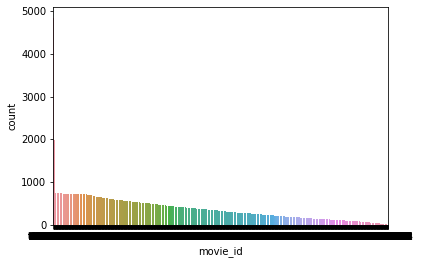

In [6]:
import seaborn as sns

sns.countplot(data = df, x = 'movie_id', order = df['movie_id'].value_counts().index)

df['movie_id'].value_counts()

We realised that some movies have a large number of reviews (more than 2000) while some movies have less than 10 reviews. <br>

We may consider to filter out movies with less than 300 reviews. (wait why?)

In [7]:
# Plot frequency of movie reviews against count of movie reviews
col = "num_reviews"
temp_df = df['movie_id'].value_counts().to_frame(name=col)
#.groupby(col).count()
temp_df.head()

,num_reviews
tt0468569,4845
tt0111161,4361
tt0167260,2729
tt0137523,2480
tt0068646,2137


<AxesSubplot: xlabel='num_reviews', ylabel='Count'>

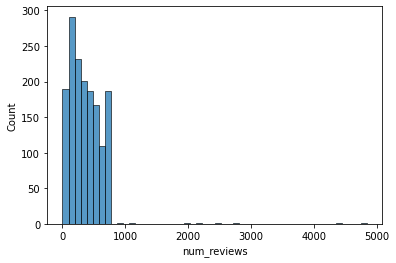

In [46]:
sns.histplot(data=temp_df, x=col, bins=50)

Find the distribution between classes. 
(spoiler or non-spoiler)

False    73.702634
True     26.297366
Name: is_spoiler, dtype: float64


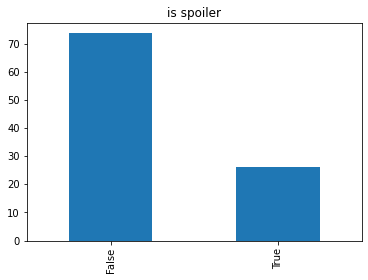

In [47]:
import matplotlib.pyplot as plt
r_has_links
spoiler_count = df.is_spoiler.value_counts(normalize = True) * 100

print(spoiler_count)

spoiler_count.plot(kind = 'bar')
plt.title('is spoiler')
plt.show()

The dataset seems to be imbalanced. <br>
Percentage of spoilers = 26.3% <br>
Percentage of non-spoilers = 73.7% <br>

We have twice the number of non-spoilers than spoliers. <br>

We have to do something about it (undersampling / oversampling) before we can train our model. <br>

In [87]:
# Exploring visually the diff between spoiler and non-spoiler
spoiler_col = "is_spoiler"


In [90]:
start = 10
end = 15
df[df[spoiler_col] == True].iloc[start:end]["review_text"].apply(lambda x: print(x))

I finally watched The Shawshank Redemption and I agree that it is an excellent film. The pacing, directing, and storyline, holds interest throughout, along with a superb supporting cast, and a very moving ending.The main character is Andy played by Tim Robbins who is imprisoned for the murder of his wife. Later on in the movie, the evidence comes out that he is truly innocent. However The Shawshank Redemption sends a powerful message that it doesn't matter whether you are innocent or not inside Shawshank penitentiary. This is because the prison is run by a sadistic and corrupt staff. In this facility, you must use all of the intellect you can, both book smarts, and street smarts to not only stay alive, but prevent yourself from going insane within the system.Andy befriends "Red," a fellow inmate, played by Morgan Freeman in another great performance. He teaches Andy street smarts of survival within Shawshank's hell-hole. Andy, an experienced banker with a master ability for finance and

10    None
11    None
12    None
13    None
14    None
Name: review_text, dtype: object

In [68]:

df[df[spoiler_col] == True].iloc[start:end]["review_summary"] 
#Seems like not super clear indicator. 
#Though spoilers tend to have facts on characters dying

0    A classic piece of unforgettable film-making.
1    Simply amazing. The best film of the 90's.   
2    The best story ever told on film             
3    Busy dying or busy living?                   
4    Great story, wondrously told and acted       
Name: review_summary, dtype: object

In [89]:
start = 0
end = 5
df[df[spoiler_col] == False].iloc[start:end]["review_text"].apply(lambda x: print(x))

Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this movie at all: I do not like prison movies and I don't normally watch them. I work at a branch library and one day as I was checking The Shawshank Redemption out to one of our older patrons, she said to me, "Whenever I feel down or depressed, I check out this movie and watch it and it always makes me feel better." At the time, I thought that was very strange. One day there was nothing on TV except things I absolutely would not watch under any circumstance or things that I had seen too many times alread

956    None
957    None
958    None
959    None
960    None
Name: review_text, dtype: object

In [69]:
df[df[spoiler_col] == False].iloc[start:end]["review_summary"] 

956    Tied for the best movie I have ever seen
957    Shawshank Redeems Hollywood             
958    This is How Movies Should Be Made       
959    Don't Rent Shawshank.                   
960    Some birds aren't meant to be caged.    
Name: review_summary, dtype: object

Certain reviews seem to contain more than one movie content, so gotta cross check against all other movie content per se

In [8]:
# Investigating how many of these have links

url_regex = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'

df["r_has_links"] = df["review_text"].str.contains(url_regex,regex=True)
df["r_has_links"].value_counts()

/tmp/ipykernel_2455015/2387160883.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["r_has_links"] = df["review_text"].str.contains(url_regex,regex=True)


True     358502
False    215411
Name: r_has_links, dtype: int64

In [10]:
group = df.groupby('r_has_links')

group_is_spoiler = df[df['is_spoiler'] == True].groupby('r_has_links')
group_no_spoiler = df[df['is_spoiler'] == False].groupby('r_has_links')
group_have_links = df[df['r_has_links'] == True].groupby('is_spoiler')
group_no_links = df[df['r_has_links'] == False].groupby('is_spoiler')

In [28]:
# df.groupby('r_has_links').count()["is_spoiler"]

r_has_links
False    215411
True     358502
Name: is_spoiler, dtype: int64

In [31]:
df.groupby('r_has_links').size()

r_has_links
False    215411
True     358502
dtype: int64

In [17]:
import matplotlib.pyplot as plt
import seaborn

# viz_df = group[['is_spoiler', 'r_has_links']]
# print(viz_df.head())
# print(viz_df.value_counts())
# # print(viz_df['r_has_links'].value_counts())
# has_spoiler = viz_df[viz_df['is_spoiler'] == True].size()#groupby('is_spoiler').count()
# has_spoiler.index
# # plt.pie(has_spoiler)

In [114]:
has_spoiler.value_counts()

422982    1
150924    1
dtype: int64

In [24]:
group_is_spoiler[['is_spoiler']].count()

,is_spoiler
r_has_links,
False,45660
True,105264


([<matplotlib.patches.Wedge at 0x7fb5b20410c0>,
 [Text(-0.6394522442151263, 0.8950423606557617, 'No Links'),
  Text(0.6394522442151261, -0.8950423606557618, 'Has At Least one')],
 [Text(-0.34879213320825064, 0.4882049239940518, '69.75%'),
  Text(0.3487921332082506, -0.48820492399405185, '30.25%')])

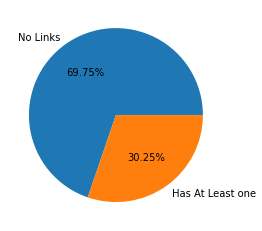

In [37]:
plt.pie(df[df['is_spoiler'] == True]['r_has_links'].value_counts(), labels=[ "Has At Least one", "No Links"], autopct='%.2f%%')

([<matplotlib.patches.Wedge at 0x7fb5ad10cc10>,
 [Text(-0.3356004655834127, 1.0475554054560536, 'Has At Least one'),
  Text(0.3356005636626263, -1.0475553740348658, 'No Links')],
 [Text(-0.1830547994091342, 0.5713938575214838, '59.87%'),
  Text(0.18305485290688706, -0.5713938403826541, '40.13%')])

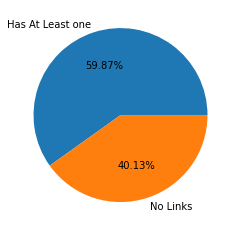

In [38]:
plt.pie(df[df['is_spoiler'] == False]['r_has_links'].value_counts(), labels=[ "Has At Least one", "No Links"], autopct='%.2f%%')

([<matplotlib.patches.Wedge at 0x7fb5ad0a5f30>,
 [Text(-0.8649880041030209, 0.6795555553138186, 'No Spoilers'),
  Text(0.8649880359153109, -0.6795555148208076, 'Has spoiler(s))')],
 [Text(-0.47181163860164765, 0.3706666665348101, '78.80%'),
  Text(0.4718116559538059, -0.3706666444477132, '21.20%')])

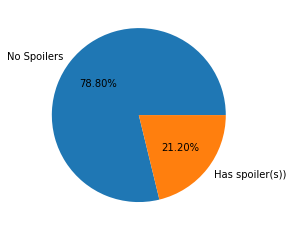

In [41]:
plt.pie(df[df['r_has_links'] == False]['is_spoiler'].value_counts(), labels=[ "No Spoilers", "Has spoiler(s))"], autopct='%.2f%%')

([<matplotlib.patches.Wedge at 0x7fb5acf70ac0>,
 [Text(-0.6642647764404961, 0.8767852113148682, 'No Spoilers'),
  Text(0.664264776440496, -0.8767852113148683, 'Has spoiler(s))')],
 [Text(-0.362326241694816, 0.47824647889901895, '70.64%'),
  Text(0.3623262416948159, -0.478246478899019, '29.36%')])

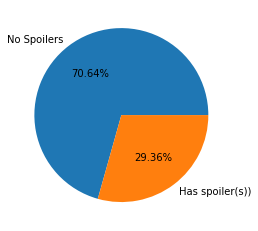

In [42]:
plt.pie(df[df['r_has_links'] == True]['is_spoiler'].value_counts(), labels=[ "No Spoilers", "Has spoiler(s))"], autopct='%.2f%%')

Simply prescense of link doesn't distinguish spoiler reivews


It may be because of the prescense of generic links like google.com

In [18]:
plt.pie(has_spoilers_link_grp, labels=["No Spoiler", "Has At Least spoiler"], autopct='%.2f%%')

NameError: name 'has_spoilers_link_grp' is not defined

## Investigating genre

Hypothesis: There may be certain genres where the user base are more toxic, thus with a higher tendency to release spoilers



In [47]:
genre_col = 'genre'

In [46]:
df[genre_col].value_counts()

[Action, Adventure, Sci-Fi]     39842
[Action, Adventure, Fantasy]    22658
[Crime, Drama]                  19258
[Drama]                         17976
[Drama, Romance]                16418
                                ...  
[Action, Comedy, Family]           34
[Adventure, Family, Romance]       32
[Comedy, Crime, Fantasy]           25
[Romance]                          18
[Family, Fantasy, Music]           12
Name: genre, Length: 237, dtype: int64

Since genre is a list, let's one hot encode this

In [49]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 11.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 7.9 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 10.1 MB/s eta 0:00:00m eta 0:00:010:01:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=5c64efff3ec4dc23ec46f41e459c1152d24cdcc8044b9b5412a28c6b5220b169
  Stored in directory: /home/randell-crapy/.cache/pip/wheels/9b/13/01/6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn


In [50]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop(genre_col)),
                index=df.index,
                columns=mlb.classes_))

In [61]:
df.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'user_rating', 'review_summary', 'plot_summary', 'duration',
       'movie_rating', 'release_date', 'plot_synopsis', 'r_has_links',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [65]:
OHE_COLS = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western']

In [66]:
df[OHE_COLS]=df[OHE_COLS].sparse.to_dense()

In [69]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,movie_rating,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,9.3,...,0,0,0,0,0,0,0,0,0,0
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,9.3,...,0,0,0,0,0,0,0,0,0,0
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,9.3,...,0,0,0,0,0,0,0,0,0,0
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,9.3,...,0,0,0,0,0,0,0,0,0,0
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,9.3,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df['Horror'].value_counts()

0    527129
1     46784
Name: Horror, dtype: int64

In [72]:
# Getting freq of different genres
OHE_freqs = {}
for col in OHE_COLS:
    print(f"col: {col}")
    print(len(df[df[col]==1]))
    OHE_freqs[col] = len(df[df[col]==1])

col: Action
190717
col: Adventure
187293
col: Animation
26597
col: Biography
33107
col: Comedy
135973
col: Crime
109670
col: Drama
289367
col: Family
39559
col: Fantasy
77098
col: Film-Noir
1791
col: History
24039
col: Horror
46784
col: Music
8756
col: Musical
5518
col: Mystery
64051
col: Romance
68301
col: Sci-Fi
95550
col: Sport
8384
col: Thriller
95223
col: War
10228
col: Western
4741


In [74]:
# df_ohe = pd.DataFrame.from_dict(OHE_freqs)
# df_ohe.head()
OHE_freqs

{'Action': 190717,
 'Adventure': 187293,
 'Animation': 26597,
 'Biography': 33107,
 'Comedy': 135973,
 'Crime': 109670,
 'Drama': 289367,
 'Family': 39559,
 'Fantasy': 77098,
 'Film-Noir': 1791,
 'History': 24039,
 'Horror': 46784,
 'Music': 8756,
 'Musical': 5518,
 'Mystery': 64051,
 'Romance': 68301,
 'Sci-Fi': 95550,
 'Sport': 8384,
 'Thriller': 95223,
 'War': 10228,
 'Western': 4741}

([<matplotlib.patches.Wedge at 0x7fb5b033eda0>,
 [Text(1.0159427019983986, 0.4217350190062397, 'Action'),
  Text(0.42577590676535704, 1.0142558243451887, 'Adventure'),
  Text(-0.0481949634865087, 1.0989436953249854, 'Animation'),
  Text(-0.18285109033780295, 1.0846960305828894, 'Biography'),
  Text(-0.5425864590739773, 0.95686986284947, 'Comedy'),
  Text(-0.9388251652711909, 0.5732428011353665, 'Crime'),
  Text(-1.0586430695569582, -0.2987889744937415, 'Drama'),
  Text(-0.6365430702158544, -0.8971136604467541, 'Family'),
  Text(-0.40436065656722603, -1.0229821403233401, 'Fantasy'),
  Text(-0.23325379052722667, -1.074984962315604, 'Film-Noir'),
  Text(-0.17566372343500386, -1.0858831687934714, 'History'),
  Text(-0.01569142454554369, -1.0998880757584981, 'Horror'),
  Text(0.11016660516389327, -1.0944694235594994, 'Music'),
  Text(0.14234500720561682, -1.090751071016496, 'Musical'),
  Text(0.29689814528930747, -1.0591749106374118, 'Mystery'),
  Text(0.5715324653151461, -0.939867352923162

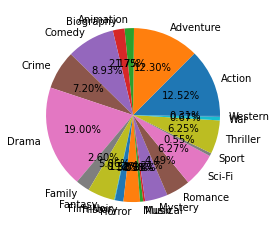

In [76]:
plt.pie(OHE_freqs.values(), labels=OHE_COLS, autopct='%.2f%%')

In [77]:
spoiler_df = df[df['is_spoiler'] == True]
no_spoiler_df = df[df['is_spoiler'] == False]

In [82]:
def get_ohe_freq(df):
    # Getting freq of different genres
    OHE_freqs = {}
    for col in OHE_COLS:
#         print(f"col: {col}")
#         print(len(df[df[col]==1]))
        OHE_freqs[col] = len(df[df[col]==1])
    return OHE_freqs

In [83]:
spoiler_freqs = get_ohe_freq(spoiler_df)
no_spoiler_freqs = get_ohe_freq(no_spoiler_df)

([<matplotlib.patches.Wedge at 0x7fb5afdf7070>,
 [Text(1.0054408267238386, 0.44619361711804456, 'Action'),
  Text(0.3450350012198785, 1.0444859251963134, 'Adventure'),
  Text(-0.16472018340490766, 1.087597012306973, 'Animation'),
  Text(-0.28831607655183605, 1.0615431409046718, 'Biography'),
  Text(-0.5789920841344582, 0.9352904182710505, 'Comedy'),
  Text(-0.9201120154579834, 0.6028215979954998, 'Crime'),
  Text(-1.0770653773349135, -0.22345060516006807, 'Drama'),
  Text(-0.7154016691730404, -0.8355838986866776, 'Family'),
  Text(-0.48539953939403313, -0.9871105749388266, 'Fantasy'),
  Text(-0.30939897716062204, -1.0555909590991963, 'Film-Noir'),
  Text(-0.2587088914646387, -1.0691443819602373, 'History'),
  Text(-0.0944140968390283, -1.09594068193405, 'Horror'),
  Text(0.03943791657861494, -1.099292795726388, 'Music'),
  Text(0.06462408426400679, -1.0981000536076113, 'Musical'),
  Text(0.23053612298933232, -1.0755710557638893, 'Mystery'),
  Text(0.5079729805886428, -0.975686143691653

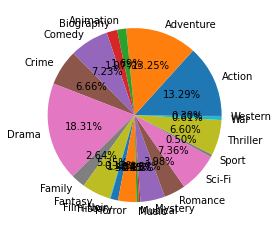

In [84]:
plt.pie(spoiler_freqs.values(), labels=OHE_COLS, autopct='%.2f%%')

([<matplotlib.patches.Wedge at 0x7fb5afb3c760>,
 [Text(1.0196062575088238, 0.4127990790310104, 'Action'),
  Text(0.4544494418429352, 1.0017363449574168, 'Adventure'),
  Text(-0.005712411949965616, 1.0999851673316845, 'Animation'),
  Text(-0.14409650794839218, 1.0905210664618448, 'Biography'),
  Text(-0.5291763056115091, 0.964350785544013, 'Comedy'),
  Text(-0.9453807172738874, 0.5623658056876418, 'Crime'),
  Text(-1.0506522464870973, -0.3257757771099866, 'Drama'),
  Text(-0.6065944119049065, -0.9176291295756368, 'Family'),
  Text(-0.3742806919921412, -1.0343664551801186, 'Fantasy'),
  Text(-0.20531159085468823, -1.0806697694766507, 'Film-Noir'),
  Text(-0.14524925077427253, -1.0903681282711415, 'History'),
  Text(0.012912257840722157, -1.0999242126607882, 'Horror'),
  Text(0.13573096232083495, -1.0915938374081544, 'Music'),
  Text(0.1703872594879927, -1.0867235995432194, 'Musical'),
  Text(0.32070579153628853, -1.0522109081714952, 'Mystery'),
  Text(0.5939861769219336, -0.9258403866896

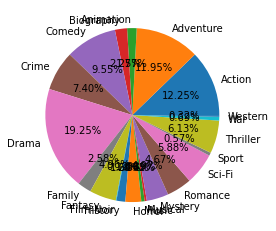

In [85]:
plt.pie(no_spoiler_freqs.values(), labels=OHE_COLS, autopct='%.2f%%')

Can conclude roughly unaffected 

## Analyzing length of reviews. 

Probably using histograms, TBC because intuitively doesn't matter

# Data processing

Fisrt, we will check for missing data.

In [78]:
count = df_reviews.isnull().sum().sort_values(ascending = False)
percentage = ((df_reviews.isnull().sum() / len(df_reviews) * 100)).sort_values(ascending = False)
missing_data = pd.concat([count,percentage] ,axis = 1, keys = ['Count', 'Percentage'])

print('Missing data in user reviews dataset')
print(missing_data)

Missing data in user reviews dataset
                Count  Percentage
review_date     0      0.0       
movie_id        0      0.0       
user_id         0      0.0       
is_spoiler      0      0.0       
review_text     0      0.0       
rating          0      0.0       
review_summary  0      0.0       


From the output above, there is no missing value in the user reviews dataset.

In [71]:
count = df_movie_details.isnull().sum().sort_values(ascending = False)
percentage = ((df_movie_details.isnull().sum() / len(df_movie_details) * 100)).sort_values(ascending = False)
missing_data = pd.concat([count,percentage] ,axis = 1, keys = ['Count','Percentage'])

print('Missing data in movie details dataset')
print(missing_data)

Missing data in movie details dataset
               Count  Percentage
movie_id       0      0.0       
plot_summary   0      0.0       
duration       0      0.0       
genre          0      0.0       
rating         0      0.0       
release_date   0      0.0       
plot_synopsis  0      0.0       


From the above output, we do not have missing value for the movie details dataset too.

In [72]:
count = df.isnull().sum().sort_values(ascending = False)
percentage = ((df.isnull().sum() / len(df) * 100)).sort_values(ascending = False)
missing_data = pd.concat([count,percentage] ,axis = 1, keys = ['Count','Percentage'])

print('Missing data in merged dataset')
print(missing_data)

Missing data in merged dataset
                Count  Percentage
review_date     0      0.0       
movie_id        0      0.0       
user_id         0      0.0       
is_spoiler      0      0.0       
review_text     0      0.0       
user_rating     0      0.0       
review_summary  0      0.0       
plot_summary    0      0.0       
duration        0      0.0       
genre           0      0.0       
movie_rating    0      0.0       
release_date    0      0.0       
plot_synopsis   0      0.0       


Find if there is any relationship between the user ratings and spoiler by plotting a bar graph.

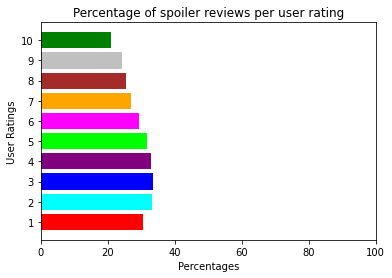

In [73]:
import matplotlib.pyplot as plt

group = df.groupby('user_rating')

group_is_spoiler = df[df['is_spoiler'] == True].groupby('user_rating')
total_review_for_vote = group.size() # Get the number of reviews foreach vote
total_spoiler_for_vote = group_is_spoiler.size() # Get the number of spoiler review foreach vote
percentage = ((total_spoiler_for_vote / total_review_for_vote) * 100)

# Print % graph

y_axis = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x_axis = percentage.tolist()

plt.barh(y_axis, x_axis,color = ['red','cyan','blue','purple','lime','magenta','orange','brown','silver','Green'])
plt.xlim(0,100)
plt.title('Percentage of spoiler reviews per user rating')
plt.ylabel('User Ratings')
plt.xlabel('Percentages')
plt.show()

From the above bar graph, it seems that lower user ratings have a higher spoiler rate.

Find is there is any relationship between movie rating and spoilers.

<AxesSubplot: xlabel='movie_rating', ylabel='Count'>

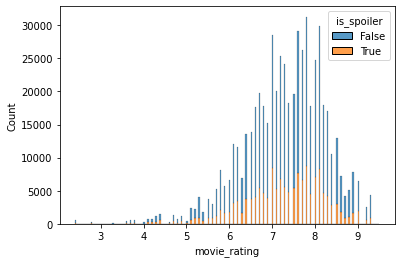

In [74]:
import seaborn as sns

group = df.groupby('movie_rating')
group_is_spoiler = df[df['is_spoiler'] == True].groupby('movie_rating')

total_review_for_vote = group.size()        
total_spoiler_for_vote = group_is_spoiler.size()   
percentage = ((total_spoiler_for_vote / totaly_axis_review_for_vote) * 100)

# plt.barh(df['movie_rating'].unique(), percentage)
# plt.xlim(0, 100)
# plt.title('Percentage of spoiler reviews per movie rating')
# plt.ylabel('Movie Ratings')
# plt.xlabel('Percentages')
# plt.show()

# plt.hist(percentage, density = True)

sns.histplot(data = df, x = 'movie_rating', hue = 'is_spoiler', multiple = 'stack')

Seems like movie rating has an inverse relationship with user rating in relation to their frequency of spoilers.

Analysis the review_text columns. <br>
Identify the reviews that contains the word 'spoiler' and find the relationship between spoilers.

In [75]:
def contains_word(word, df):
  col_name = 'contains_word_' + word
  df[col_name] = df['review_text'].apply(lambda text: word in text.upper())
  return df

In [77]:
df = contains_word('SPOILER', df)
df.describe()

,user_rating,movie_rating
count,573913.000000,573913.000000
mean,6.954254,7.293664
std,2.956295,0.959343
min,1.000000,2.400000
25%,5.000000,6.700000
50%,8.000000,7.400000
75%,10.000000,8.000000
max,10.000000,9.500000


In [83]:
df_has_spoil = contains_word('SPOILER', df)
df_has_spoil.describe(include="all")

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,contains_word_SPOILER
count,573906,573906,573906,573906,573906,573906.00000,573906,573906,573906,573906,573906.000000,573906,573906,573906
unique,7104,1570,263404,2,573378,NaN,499042,1570,132,237,NaN,1207,1340,2
top,17 December 2003,tt0468569,ur2898520,False,"I have never seen such an amazing film since I saw The Shawshank Redemption. Shawshank encompasses friendships, hardships, hopes, and dreams. And what is so great about the movie is that it moves you, it gives you hope. Even though the circumstances between the characters and the viewers are quite different, you don't feel that far removed from what the characters are going through.It is a simple film, yet it has an everlasting message. Frank Darabont didn't need to put any kind of outlandish special effects to get us to love this film, the narration and the acting does that for him. Why this movie didn't win all seven Oscars is beyond me, but don't let that sway you to not see this film, let its ranking on the IMDb's top 250 list sway you, let your friends recommendation about the movie sway you.Set aside a little over two hours tonight and rent this movie. You will finally understand what everyone is talking about and you will understand why this is my all time favorite movie.",NaN,Disappointing,"Set within a year after the events of Batman Begins, Batman, Lieutenant James Gordon, and new district attorney Harvey Dent successfully begin to round up the criminals that plague Gotham City until a mysterious and sadistic criminal mastermind known only as the Joker appears in Gotham, creating a new wave of chaos. Batman's struggle against the Joker becomes deeply personal, forcing him to ""confront everything he believes"" and improve his technology to stop him. A love triangle develops between Bruce Wayne, Dent and Rachel Dawes. Written by\nLeon Lombardi",1h 47min,"[Action, Adventure, Sci-Fi]",NaN,1994-10-14,,False
freq,355,4845,1303,422982,16,NaN,794,4845,13454,39842,NaN,6578,35078,547470
mean,NaN,NaN,NaN,NaN,NaN,6.95427,NaN,NaN,NaN,NaN,7.293693,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,2.95629,NaN,NaN,NaN,NaN,0.959311,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,2.400000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,5.00000,NaN,NaN,NaN,NaN,6.700000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,8.00000,NaN,NaN,NaN,NaN,7.400000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,10.00000,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN


In [85]:
df["contains_word_SPOILER"].value_counts()

False    547470
True     26436 
Name: contains_word_SPOILER, dtype: int64

Text(0.5, 1.0, 'Spoiler reviews')

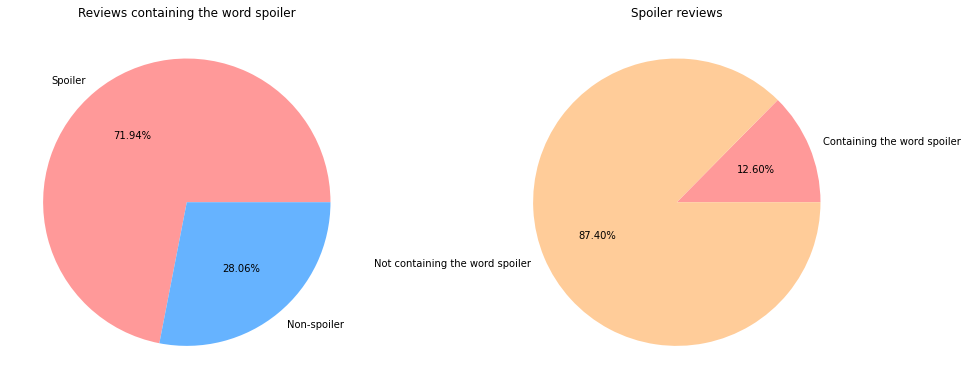

In [86]:
import matplotlib.pyplot as plt
import numpy as np

num_of_spoiler = df[df['is_spoiler'] == True].shape[0]
num_of_spoiler_with_spoiler_word = df[(df['is_spoiler'] == True) & (df['contains_word_SPOILER'] == True)].shape[0]
num_of_non_spoiler_with_spoiler_word = df[(df['is_spoiler'] == False) & (df['contains_word_SPOILER'] == True)].shape[0]
num_of_reviews_with_spoiler_word = df[df['contains_word_SPOILER'] == True].shape[0]

# plot 2 pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15)) 
fig.tight_layout(pad = 10.0)

labels = ['Spoiler', 'Non-spoiler']
values = np.array([(num_of_spoiler_with_spoiler_word / num_of_reviews_with_spoiler_word) * 100,
           (num_of_non_spoiler_with_spoiler_word / num_of_reviews_with_spoiler_word) * 100])
ax1.pie(values, labels = labels, colors = ['#ff9999','#66b3ff'], autopct = '%1.2f%%')
ax1.set_title('Reviews containing the word spoiler')

labels = ['Containing the word spoiler', 'Not containing the word spoiler']
values = np.array([(num_of_spoiler_with_spoiler_word / num_of_spoiler) * 100,
           ((num_of_spoiler - num_of_spoiler_with_spoiler_word) / num_of_spoiler) * 100])
ax2.pie(values,labels = labels, colors = ['#ff9999', '#ffcc99'],autopct = '%1.2f%%') #plot second pie
ax2.set_title('Spoiler reviews')

From the pie charts above, for the reviews that contain the word 'spoiler', 71.9% are spoilers and 24.1% are non-spoilers. <br>

Out of the all spoilers' reviews, only 12.6% conatains the word spoiler. 87.4% of the spoiler reviews do not contain the word spoiler. Therefore there seems to be much correlation to the occurance of the word 'spoiler' to whether a review is deemed a spoiler.


## Picking a Movie

In [ ]:
def pick_movie(movie_id):
  global df
  df = df.loc[df['movie_id'] == movie_id, :]

In [ ]:
pick_movie('tt0468569')

In [ ]:
df.reset_index(inplace=True)
df = df.drop('index', axis=1)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis,contains_word_SPOILER
0,20 July 2008,tt0468569,ur1293485,True,I got to see The Dark Knight on Wednesday nigh...,10,The Batman of our dreams! So much more than a ...,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False
1,16 July 2008,tt0468569,ur13846894,True,I must say I was excited for this movie since ...,10,Certainly Dark - Worth The Wait,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False
2,16 July 2008,tt0468569,ur2371300,True,I thought Batman Begins was a very well concei...,10,Best. Comic. Movie. EVER.,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False
3,16 July 2008,tt0468569,ur5237888,True,I think the big question...or the question eve...,10,The Dark Knight is as good as everyone says an...,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False
4,17 July 2008,tt0468569,ur2747265,True,(Synopsis) Bruce Wayne/Batman (Christian Bale)...,10,The dark and sinister mood of the film really ...,Set within a year after the events of Batman B...,2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,The movie begins with a gang of men with clown...,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_date            4845 non-null   object 
 1   movie_id               4845 non-null   object 
 2   user_id                4845 non-null   object 
 3   is_spoiler             4845 non-null   bool   
 4   review_text            4845 non-null   object 
 5   user_rating            4845 non-null   int64  
 6   review_summary         4845 non-null   object 
 7   plot_summary           4845 non-null   object 
 8   duration               4845 non-null   object 
 9   genre                  4845 non-null   object 
 10  movie_rating           4845 non-null   float64
 11  release_date           4845 non-null   object 
 12  plot_synopsis          4845 non-null   object 
 13  contains_word_SPOILER  4845 non-null   bool   
dtypes: bool(2), float64(1), int64(1), object(10)
memory usag

## Under-sampling

This is done before data cleaning.

In [ ]:
def under_sampling():
    global df
    df_0 = df[df['is_spoiler'] == False]
    df_1 = df[df['is_spoiler'] == True]
    sample_size = df_1.shape[0]
    df_0 = df_0.sample(sample_size)
    df = pd.concat([df_0, df_1])


In [ ]:
under_sampling()

In [ ]:
df.reset_index(inplace=True)
df = df.drop('index', axis=1)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis,contains_word_SPOILER
0,30 June 2002,tt0167404,ur1821533,False,"I saw this film in the U.S. when I was there, ...",10,M. Night Shyamalan - remember that name!,Malcom Crowe (Bruce Willis)is a child psycholo...,1h 47min,"[Drama, Mystery, Thriller]",8.1,1999-08-06,"Dr. Malcolm Crowe (Bruce Willis), a prominent ...",False
1,27 July 2015,tt1937390,ur0278527,False,Apparently this film has received considerable...,5,"So, I Saw This Title on Netflix.....",A man named Seligman finds a fainted wounded w...,1h 57min,[Drama],7.0,2014-03-06,The film starts with a repetitive sound effect...,False
2,26 December 2016,tt4550098,ur56801091,False,"Well, after Amy Adams picking this flop and th...",2,"Little hope for Adams' ""Dis-Enchanted""","A ""story inside a story,"" in which the first p...",1h 56min,"[Crime, Drama, Romance]",7.5,2016-12-09,"The movie begins with obese women, dancing nak...",False
3,3 November 2007,tt0765429,ur5118543,False,"When I first heard about this film, I was hope...",5,Irresponsible and Dull,Following the death of his employer and mentor...,2h 37min,"[Biography, Crime, Drama]",7.8,2007-11-02,The film opens with Bumpy Johnson (Clarence Wi...,False
4,3 March 2007,tt0443706,ur6663090,False,"After having read other critiques, I will conc...",9,A fresh take on the elusive serial killer....,A serial killer in the San Francisco Bay Area ...,2h 37min,"[Crime, Drama, History]",7.7,2007-03-02,"The film starts on July 4, 1969, with the Zodi...",False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301848 entries, 0 to 301847
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   review_date            301848 non-null  object 
 1   movie_id               301848 non-null  object 
 2   user_id                301848 non-null  object 
 3   is_spoiler             301848 non-null  bool   
 4   review_text            301848 non-null  object 
 5   user_rating            301848 non-null  int64  
 6   review_summary         301848 non-null  object 
 7   plot_summary           301848 non-null  object 
 8   duration               301848 non-null  object 
 9   genre                  301848 non-null  object 
 10  movie_rating           301848 non-null  float64
 11  release_date           301848 non-null  object 
 12  plot_synopsis          301848 non-null  object 
 13  contains_word_SPOILER  301848 non-null  bool   
dtypes: bool(2), float64(1), int64(1), ob

False    50.0
True     50.0
Name: is_spoiler, dtype: float64


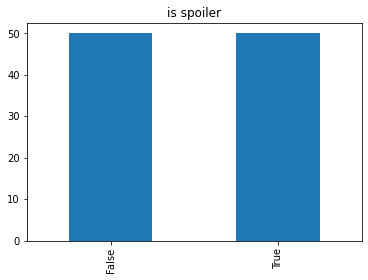

In [ ]:
import matplotlib.pyplot as plt
spoiler_count = df.is_spoiler.value_counts(normalize = True) * 100

print(spoiler_count)

spoiler_count.plot(kind = 'bar')
plt.title('is spoiler')
plt.show()

Now the dataset is balanced!

## Size Reduction

In [ ]:
def reduce_data_size():
    global df
    frac = 0.1
    df = df.sample(frac=frac)

In [ ]:
reduce_data_size()

In [ ]:
df.reset_index(inplace=True)
df = df.drop('index', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30185 entries, 0 to 30184
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_date            30185 non-null  object 
 1   movie_id               30185 non-null  object 
 2   user_id                30185 non-null  object 
 3   is_spoiler             30185 non-null  bool   
 4   review_text            30185 non-null  object 
 5   user_rating            30185 non-null  int64  
 6   review_summary         30185 non-null  object 
 7   plot_summary           30185 non-null  object 
 8   duration               30185 non-null  object 
 9   genre                  30185 non-null  object 
 10  movie_rating           30185 non-null  float64
 11  release_date           30185 non-null  object 
 12  plot_synopsis          30185 non-null  object 
 13  contains_word_SPOILER  30185 non-null  bool   
dtypes: bool(2), float64(1), int64(1), object(10)
memory us

## Data Cleaning

In [ ]:
import re
def removeLinks(text):
  return re.sub(r'http\S+', '', text)
print(removeLinks('here is a link: https://google.com'))

here is a link: 


First, we will remove the links in the review_text column.

In [ ]:
for i in df.index:
  df.at[i, 'review_text'] = removeLinks(df.at[i, 'review_text'])

Next, we will expand contraction words.

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 7.3 MB/s 
     |████████████████████████████████| 287 kB 25.9 MB/s 


In [ ]:
import contractions
def expandContractions(text):
  expandedWords = []
  for word in text.split():
    expandedWords.append(contractions.fix(word))  
  return ' '.join(expandedWords)
print(expandContractions('I\'ve completed this function'))

I have completed this function


In [ ]:
for i in df.index:
  df.at[i, 'review_text'] = expandContractions(df.at[i, 'review_text'])

Then, we do stopwords removal.



In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Stop words removal
# Stemming
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stop_words_set = set(stopwords.words('english'))
def myAnalyzer(text):
  text_words = analyzer(text)
  words = []
  for word in text_words:
    stemmed_word = stemmer.stem(word)
    # if stemmed_word not in stop_words_set:
    #   words.append(stemmed_word)
    words.append(stemmed_word)
  return words

We will count the total number of words left in each review text. Before counting the words, we need to remove all the special character.

In [ ]:
import string

def remove_special_character(sentence):
  pattern = r"[^a-zA-Z]"
  sentence = re.sub(pattern, ' ', sentence)
  return sentence

def word_count(sentence):
  num = len(sentence.split())
  # num = sum([i.strip(string.punctuation).isalpha() for i in sentence.split()])
  return num

In [ ]:
for i in df.index:
  df.at[i, 'review_text'] = remove_special_character(df.at[i, 'review_text'])
  df.at[i, 'review_text_word_count'] = word_count(df.at[i, 'review_text'])

df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,user_rating,review_summary,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis,contains_word_SPOILER,review_text_word_count
0,7 February 2003,tt0208092,ur1937029,False,While its not as good as LSATSB it comes clos...,9,Cool movie,Turkish and his close friend/accomplice Tommy ...,1h 42min,"[Comedy, Crime]",8.3,2001-01-19,The film opens as we see boxing promoter Turki...,False,116.0
1,12 November 2013,tt1951264,ur43364424,False,OK so I have been going through these reviews ...,10,This is not about the Hunger Games!,Twelve months after winning the 74th Hunger Ga...,2h 26min,"[Action, Adventure, Mystery]",7.5,2013-11-22,Six months after winning the 74th Hunger Games...,False,325.0
2,8 May 2015,tt2661044,ur51687135,True,If you could get page the fact that only attra...,7,It's a nice show,The series is set 97 years after a devastating...,43min,"[Drama, Mystery, Sci-Fi]",7.8,2014-05-03,"Story is post nuclear, according to the narrat...",False,310.0
3,18 February 2000,tt0124315,ur0161567,False,My wife and I who are something is loved th...,10,From a couple of seniors,"Homer is an orphan in remote St. Cloud, Maine....",2h 6min,"[Drama, Romance]",7.4,2000-01-07,"Homer Wells (Tobey Maguire), an orphan, is the...",False,43.0
4,25 December 2017,tt0068646,ur81865706,True,I love this movie The continuation is also ex...,10,Love this,When the aging head of a famous crime family d...,2h 55min,"[Crime, Drama]",9.2,1972-03-24,"In late summer 1945, guests are gathered for t...",False,39.0


# Feature extracting

In [ ]:
review_text = df['review_text'].to_list()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
analyzer = TfidfVectorizer().build_analyzer()
vectorizer = TfidfVectorizer(analyzer=myAnalyzer, min_df=0.01)


In [ ]:
# test_vectorizer = TfidfVectorizer(analyzer=myAnalyzer)
# test_counts = test_vectorizer.fit_transform(('Here\'s not an example!!!',
#   'There is a man who loves study', 
#   'I\'ve been STUDYING',
#   'What is this iiii',
#   'I\'ve been tmr learning cooool',
#   'What is that tomorrow',
#   'It is an apple mans'))
# print(test_vectorizer.get_feature_names_out())
# print(test_counts.toarray())

In [ ]:
review_text_tfidf = vectorizer.fit_transform(review_text)

# Models

In [ ]:
import pandas as pd

In [ ]:
review_text_tfidf_df = pd.DataFrame(review_text_tfidf.toarray())
review_text_tfidf_df.head()

In [ ]:
labels = df['is_spoiler'].to_list()
print(len(labels))
print(review_text_tfidf_df.shape[0])

2964
2964


In [ ]:
review_text_tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964 entries, 0 to 2963
Columns: 12512 entries, 0 to 12511
dtypes: float64(12512)
memory usage: 282.9 MB


## SVM

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(review_text_tfidf_df, labels, train_size = 0.8)

In [ ]:
import numpy as np
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(x_train, y_train)

SVC()

In [ ]:
svc_clf.score(x_test, y_test)

0.6526138279932546

🤣